# Short Leaf Pine Vs. Pitch Pine

### The goal:
Bring in the forest inventory data from the consultant and try to correct the errors in the species identification of Pitch Pine and/or Short Leaf. These two species are somewhat difficult to ID between each other and can easily get mixed up.


### Workflow
1. Bring in raw data
2. Clean up (formating, NA's, etc.)
3. EDA
4. Model
    - Split data into traning and test sets
    - Use SVM or Logistic Regression 
        - These algo's are good for binary classification
        - Use meteric report to a assess model performance (precision, recall, f1-score), confusion maxtrix, and ROC Curve
5. Results

In [102]:
## Lib's needed
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from __future__ import print_function
# Import for spliting the data set
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
# Imports for classificaiton 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
# Model performance
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import metrics as mt

# Set the figure sizes for the project 
rcParams['figure.figsize'] = 10, 10
rcParams.update({'font.size': 18})

## Bring in data and perform some EDA

In [4]:
def corr_matrix(df):
    '''Generates Correlation Matrix'''
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (15, 10))
    colormap = sns.diverging_palette(240, 10, n = 9, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = colormap, center = 0,
                square = True, linewidths = .5, cbar_kws = {"shrink": 1})

In [87]:
# Now that we have a data dictionary, we can get rid of many of the irrelevant columns. 
# I selected this particular subset also using some forestry knowledge (doubtful of the 
# various volume variables contribution to crown class)
fields = ['CLUSTER','ID',
'tree_obs_id','tree_spp',
'tree_dbh','tree_stems',
'tree_height','tree_crown_class',
'tree_stems_per','tree_ba',
'stand_id','OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id'
]

#Create a dataframe from just the subset of cols using same dataset from original notebook.
raw_trees = pd.read_csv("FinalOverObTableWAR.csv", usecols = fields)



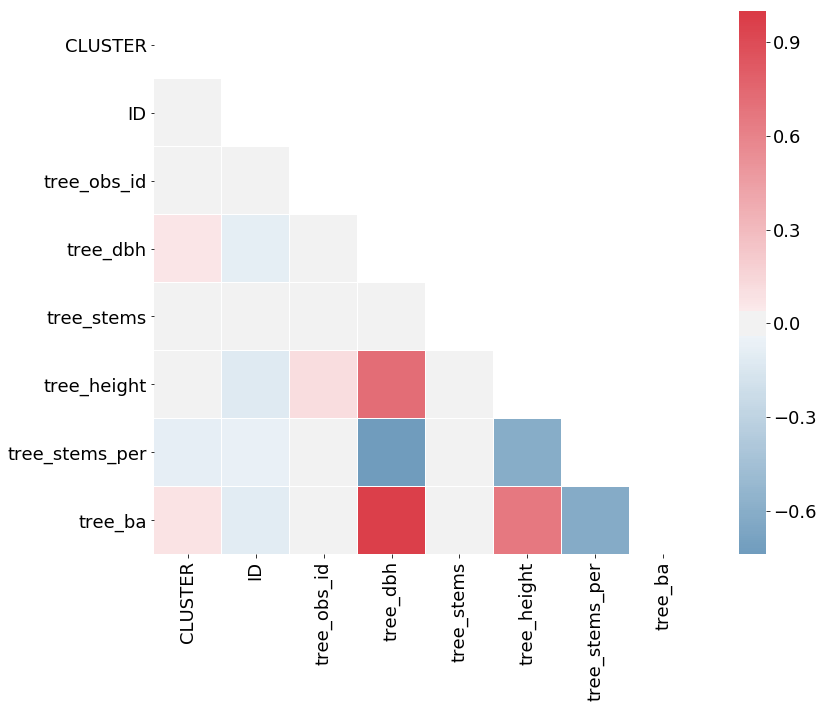

In [88]:
corr_matrix(raw_trees)

## Feature Engineering

In [89]:
fe_data = raw_trees

In [90]:
fe_data['tree_height_cont'] = fe_data['tree_height'] + [random.random() for _ in range(0, len(fe_data))]
fe_data['ht_percentile_stand'] = fe_data.groupby('stand_id')['tree_height_cont'].rank(pct=True)
fe_data['BA_percentile_stand'] = fe_data.groupby('stand_id')['tree_ba'].rank(pct=True)
fe_data['ht_percentile_plot'] = fe_data.groupby('OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id')['tree_height_cont'].rank(pct=True)
fe_data['BA_percentile_plot'] = fe_data.groupby('OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id')['tree_ba'].rank(pct=True)
fe_data['ht_percentile_ratio'] = fe_data['ht_percentile_plot'] / fe_data['ht_percentile_stand'] 
fe_data['BA_percentile_ratio'] = fe_data['BA_percentile_plot'] / fe_data['BA_percentile_stand']

In [91]:
fe_data.shape

(16575, 19)

In [92]:
# Let's take out some variable's e dont need
tree_data = fe_data.drop(
    labels=[
        'CLUSTER', 
        'ID', 
        'OverOb_wOverIDForTypBAFGrndPresCrzrSoilWet_over_id',
        'tree_crown_class',
        'stand_id'
    ],
    axis=1
)

In [93]:
tree_data.tail()

,tree_obs_id,tree_spp,tree_dbh,tree_stems,tree_height,tree_stems_per,tree_ba,tree_height_cont,ht_percentile_stand,BA_percentile_stand,ht_percentile_plot,BA_percentile_plot,ht_percentile_ratio,BA_percentile_ratio
16570,3,NYSY,11,1,35,15.152603,0.659953,35.892847,0.219764,0.721976,0.250,0.7500,1.137584,1.038815
16571,5,NYSY,10,1,45,18.334649,0.545415,45.151488,0.393805,0.624631,0.500,0.4375,1.269663,0.700413
16572,8,ACRU,8,1,35,28.647890,0.349066,35.906002,0.220501,0.399336,0.375,0.1250,1.700669,0.313019
16573,10,PIRI,10,1,55,18.334649,0.545415,55.225885,0.730088,0.624631,0.625,0.4375,0.856061,0.700413
16574,9,PIRI,10,1,60,18.334649,0.545415,60.587922,0.891593,0.624631,0.750,0.4375,0.841191,0.700413


In [81]:
# for tree in tree_data['tree_spp'].unique():
#     print(tree)

In [94]:
# Let's subset for all of the pines
pitch_short = [
    'PIRI',
    'PIEC2',
]
# Subset
pines = tree_data.loc[tree_data['tree_spp'].isin(pitch_short)]
print(pines.shape)

(13059, 14)


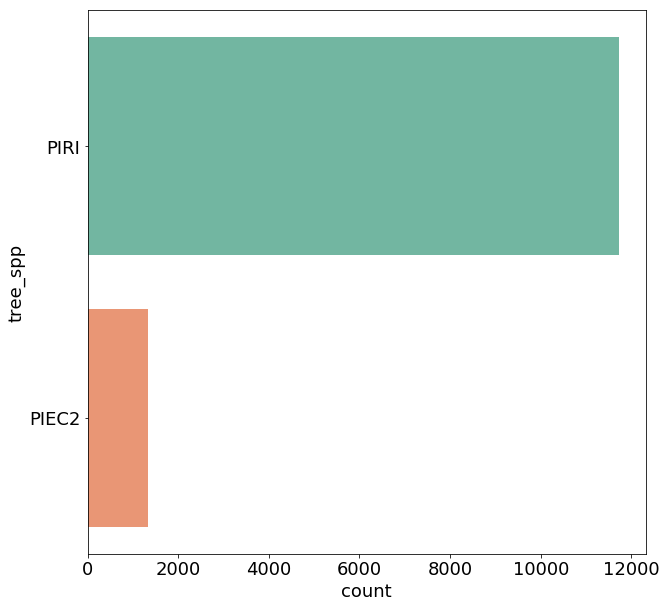

In [95]:
# Get histo of tree spp
tree_spp_distribution = sns.countplot(
    y="tree_spp",
    orient='h',
    palette="Set2",
    data=pines
)
tree_spp_distribution

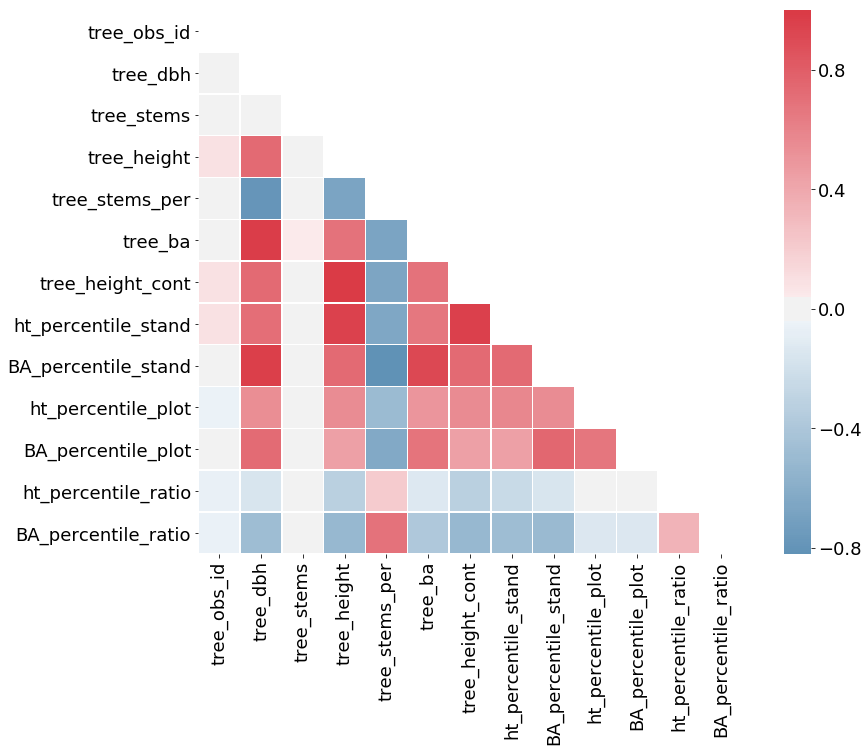

In [96]:
corr_matrix(pines)

In [111]:
# Need to convert 'tree_spp' into binary for classification, mainly for th ROC Curve
# PIRI = 0 
# PIEC2 = 1
pines['tree_spp'] = pines['tree_spp'].apply(lambda x: x.replace('PIEC2', '1'))
pines['tree_spp'] = pines['tree_spp'].apply(lambda x: x.replace('PIRI', '0'))
pines['tree_spp'] = pines['tree_spp'].astype(int)

## Splitting the data into training and testing sets

The goal of performing cross-validation is to split our data into a training set and test set. The training set is split up into multiple validation sets. We are going to use stratified K-fold cross-validation with 10 splits (K=10) for our classification tasks. This is because our data is unbalanced. There is a total of 17,426 observations in our data set. Out of all the observations, 8,022 observations are made up of co-dominate trees (about half). Stratified K-fold cross-validation ensures that each of our training sets contains an equal proportion of each unbalanced variable.

In [98]:
# Here we will use the Stratified Shuffle Split method. This is result in a number of stratified folds. 
# The folds are made by preserving the percentage of samples for each class.
# Since our data is highly imbalanced this method will make sure this imbalance wont bias the model.
# We don't need tro scale the data here because Logisitc Regression dones not require input features to be scaled.

# Split the data into traning (80%) and test set (20%)
model_pines = pines.copy()
if 'tree_spp' in model_pines:
    # Get values we need 
    y = model_pines['tree_spp'].values
    # Get rid of the class label
    del model_pines['tree_spp']
    # Use everything else to classify 
    X = model_pines.values

# One-hot encode the features
X = pd.get_dummies(model_pines).values

# Split the data into 20% Test and 80% Train using StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.20, random_state=111)
# Retreving the splits
print("There are", sss.get_n_splits(X, y), "splits")

There are 3 splits


In [99]:
print("These are the Stratified Shuffle Split parameters:")
print("---------------------------------------------------")
print(sss)

These are the Stratified Shuffle Split parameters:
---------------------------------------------------
StratifiedShuffleSplit(n_splits=3, random_state=111, test_size=0.2,
            train_size=None)


In [100]:
# Create a for loop that grabs the values for each fold for traing and test sets
for train_index, test_index in sss.split(X, y):
    # Let's print them out just for a sanity check
    print("TRAIN:", train_index, "TEST:", test_index)
    # Create the X train/test and y train/test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [12787  4374  8936 ...  9543  7990  2668] TEST: [11791  9323  3836 ... 12274  4203  5419]
TRAIN: [11609  8375 10767 ...  1550  6522  7554] TEST: [1151 6919 3288 ... 7194 7623 2570]
TRAIN: [11495 12935 10672 ...  1362  6902  7237] TEST: [ 7320 12855  5620 ...  5594    63  1968]


## Let's Classify
Now thaat we have our training and testing sets, we will use the Logistic Regression method. At the end of this section we will assess the precision, recall, f1-score, and support.

### Logistic Regression

Logistic Regression Metric Report
              precision    recall  f1-score   support

           0       0.94      0.65      0.77      2346
           1       0.17      0.64      0.27       266

   micro avg       0.65      0.65      0.65      2612
   macro avg       0.56      0.64      0.52      2612
weighted avg       0.86      0.65      0.72      2612



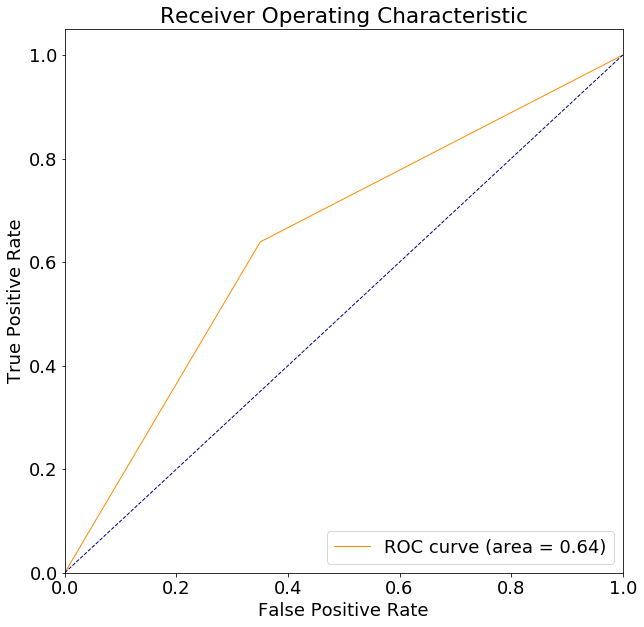

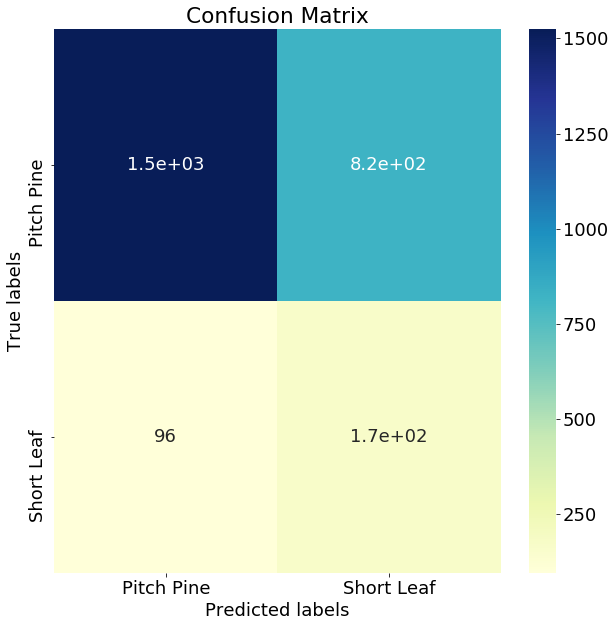

Logistic Regression Metric Report
              precision    recall  f1-score   support

           0       0.95      0.64      0.76      2346
           1       0.17      0.68      0.28       266

   micro avg       0.64      0.64      0.64      2612
   macro avg       0.56      0.66      0.52      2612
weighted avg       0.87      0.64      0.71      2612



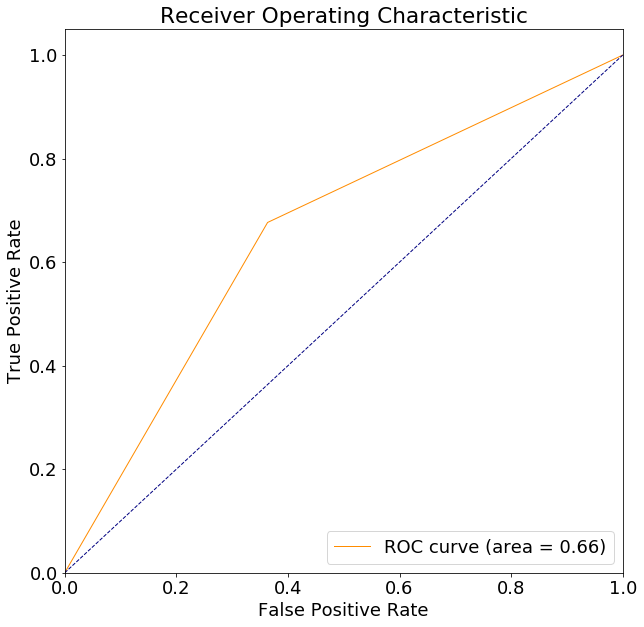

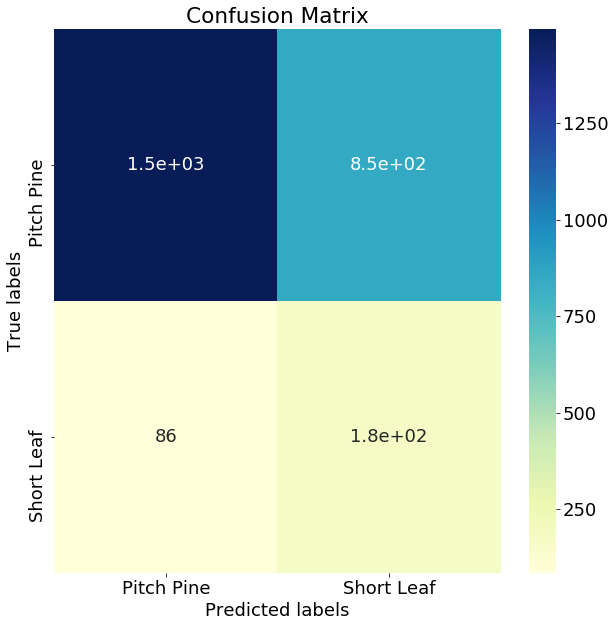

Logistic Regression Metric Report
              precision    recall  f1-score   support

           0       0.93      0.65      0.77      2346
           1       0.16      0.60      0.26       266

   micro avg       0.65      0.65      0.65      2612
   macro avg       0.55      0.63      0.51      2612
weighted avg       0.86      0.65      0.72      2612



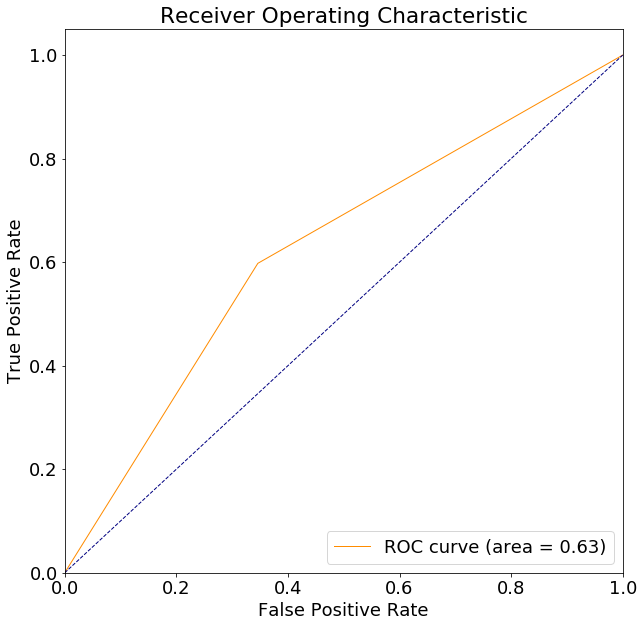

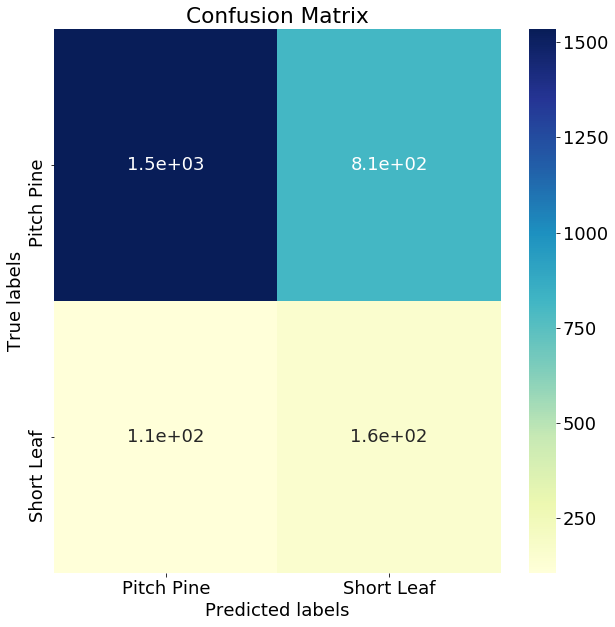

In [112]:
"""
Logistic Regression

penalty -> Specifies the norm used in the penalization. Here we use the default 'L2' or 
    Euclidean norm/distance.
    In other words the sum of the squares of the elements gives one.
solver -> 'liblinear' is used here.
    For small datasets, ‘liblinear’ is a good choice
dual -> Select the algorithm to either solve the dual or primal optimization problem. 
    Prefer dual=False 
    when n_samples > n_features.
class_weight -> The “balanced” mode uses the values of y to automatically adjust weights 
    inversely proportional to class frequencies in the input data as 
    n_samples / (n_classes * np.bincount(y)).
C -> Inverse of regularization strength; must be a positive float. 
    Like in support vector machines, smaller values specify stronger regularization.
"""

logit = LogisticRegression(
    C=0.5,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    max_iter=150,
    dual=False,
    random_state = 111,
)

# Now we want to iterate through and grab the prediction
iter_num = 0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X, y):
    # Train indices for X
    X_train = X[train_indices]
    # Train indices for y
    y_train = y[train_indices]
    # Test indices for X
    X_test = X[test_indices]
    # Test indices for y
    y_test = y[test_indices]
    
    # Train the reusable SVM classifier on the training data
    logit.fit(X_train, y_train)
    # Get the test set predictions 
    y_hat = logit.predict(X_test)
    
    # Metric report 
    metrics_logit = classification_report(
        y_test,
        y_hat
    )
    print('Logistic Regression Metric Report')
    print(metrics_logit)
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(
        y_test,
        y_hat
    )
    roc_auc = auc(
        fpr,
        tpr
    )
    # Plot ROC Curve
    plt.figure()
    plt.plot(
        fpr,
        tpr,
        color='darkorange',
        lw=1,
        label='ROC curve (area = %0.2f)' % roc_auc
    )
    plt.plot(
        [0, 1],
        [0, 1],
        color='navy',
        lw=1,
        linestyle='--'
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Confusion Matrix
    logit_confusion_matrix = confusion_matrix(
        y_test,
        y_hat
    )
    # Plot Confusion matrix
    ax = plt.subplot()
    sns.heatmap(
        logit_confusion_matrix,
        annot=True,
        cmap="YlGnBu",
        ax=ax
    )
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Pitch Pine', 'Short Leaf'])
    ax.yaxis.set_ticklabels(['Pitch Pine', 'Short Leaf'])
    plt.show()
    # run through the first iteration, then second, then third ... then tenth
    iter_num += 1

### Linear SVM

Logistic Regression Metric Report
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      2346
           1       0.17      0.65      0.27       266

   micro avg       0.64      0.64      0.64      2612
   macro avg       0.56      0.65      0.51      2612
weighted avg       0.86      0.64      0.71      2612



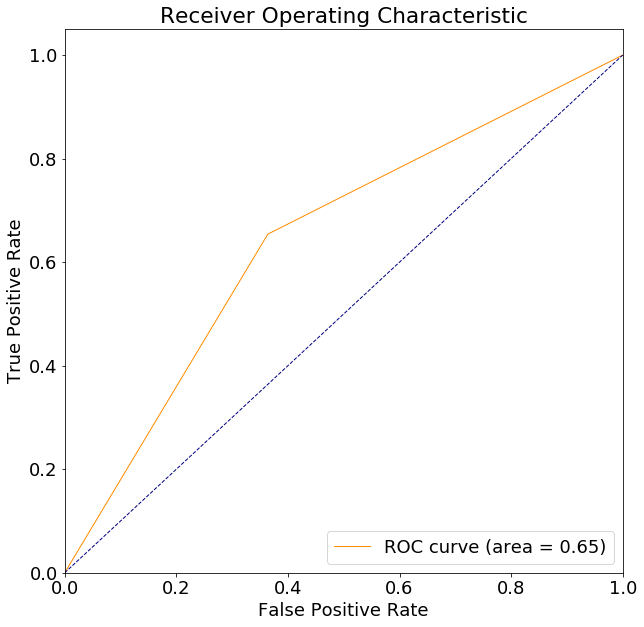

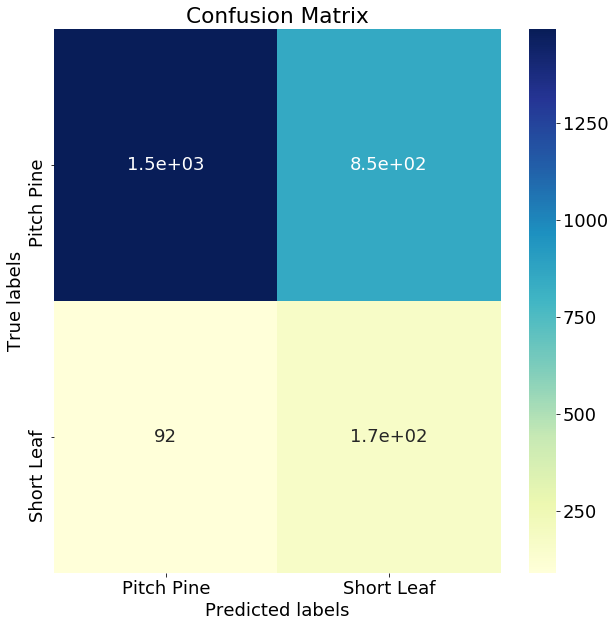

Logistic Regression Metric Report
              precision    recall  f1-score   support

           0       0.94      0.62      0.75      2346
           1       0.17      0.68      0.27       266

   micro avg       0.63      0.63      0.63      2612
   macro avg       0.56      0.65      0.51      2612
weighted avg       0.87      0.63      0.70      2612



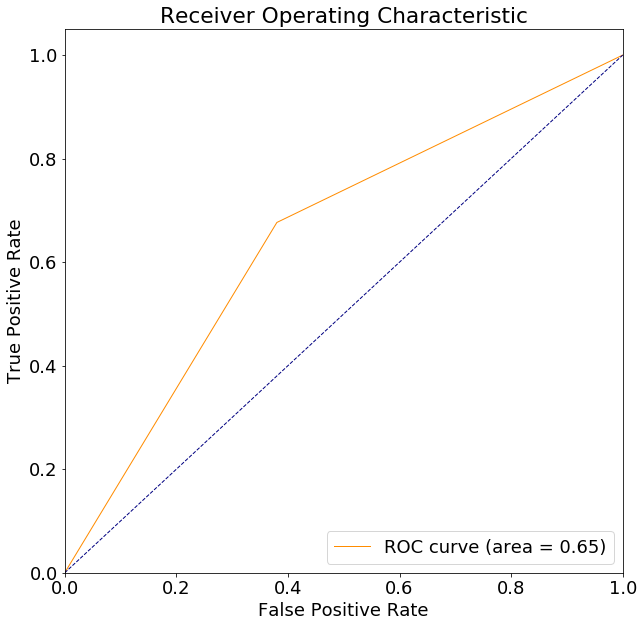

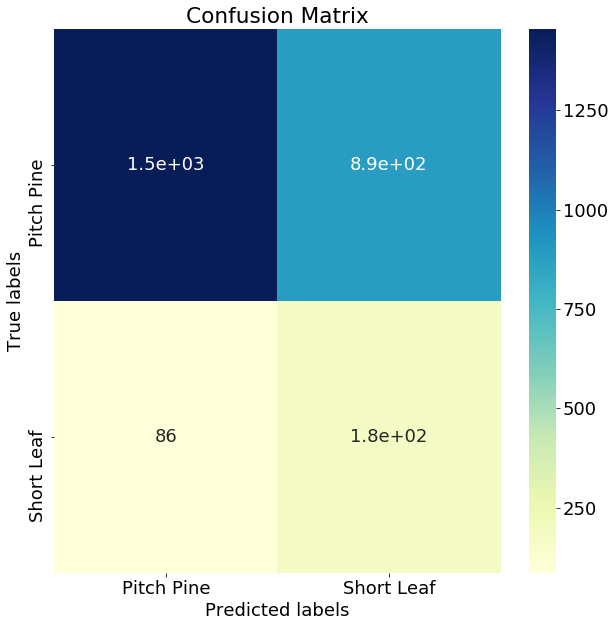

Logistic Regression Metric Report
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      2346
           1       0.16      0.61      0.26       266

   micro avg       0.64      0.64      0.64      2612
   macro avg       0.55      0.63      0.51      2612
weighted avg       0.86      0.64      0.71      2612



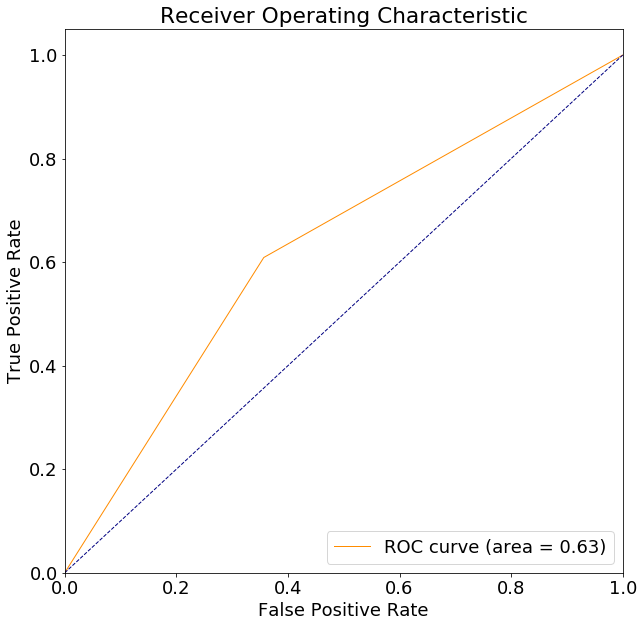

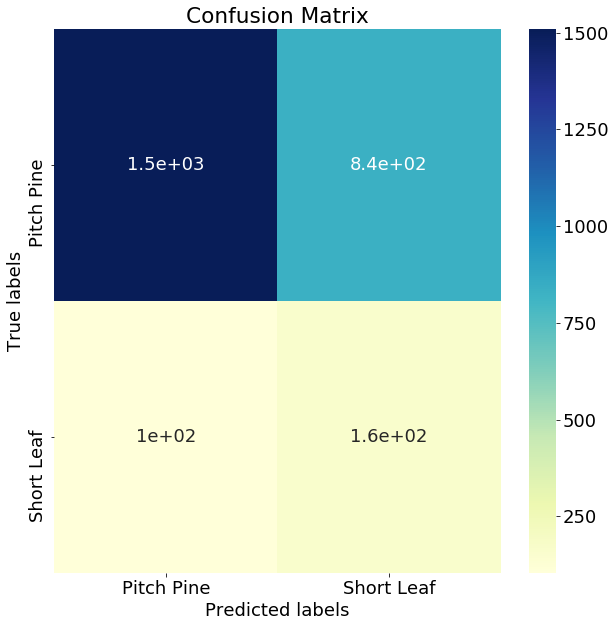

In [113]:
"""
Linear SVM

penalty -> Specifies the norm used in the penalization. Here we use the default 'L2' or 
    Euclidean norm/distance.In other words the sum of the squares of the elements gives one.
dual -> Select the algorithm to either solve the dual or primal optimization problem. 
    Prefer dual=False 
    when n_samples > n_features.
class_weight -> The “balanced” mode uses the values of y to automatically adjust weights 
    inversely proportional to class frequencies in the input data as 
    n_samples / (n_classes * np.bincount(y)).
C -> Inverse of regularization strength; must be a positive float. 
    Like in support vector machines, smaller values specify stronger regularization.
"""

SVM = LinearSVC(
    class_weight='balanced',
    penalty='l2',
    C=2.0,
    dual=False,
    random_state = 111
)

# Now we want to iterate through and grab the prediction
iter_num = 0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X, y):
    # Train indices for X
    X_train = X[train_indices]
    # Train indices for y
    y_train = y[train_indices]
    # Test indices for X
    X_test = X[test_indices]
    # Test indices for y
    y_test = y[test_indices]
    
    # Train the reusable SVM classifier on the training data
    SVM.fit(X_train, y_train)
    # Get the test set predictions 
    y_hat = SVM.predict(X_test)
    
    # Metric report 
    metrics_SVM = classification_report(
        y_test,
        y_hat
    )
    print('Logistic Regression Metric Report')
    print(metrics_SVM)
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(
        y_test,
        y_hat
    )
    roc_auc = auc(
        fpr,
        tpr
    )
    # Plot ROC Curve
    plt.figure()
    plt.plot(
        fpr,
        tpr,
        color='darkorange',
        lw=1,
        label='ROC curve (area = %0.2f)' % roc_auc
    )
    plt.plot(
        [0, 1],
        [0, 1],
        color='navy',
        lw=1,
        linestyle='--'
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Confusion Matrix
    SVM_confusion_matrix = confusion_matrix(
        y_test,
        y_hat
    )
    # Plot Confusion matrix
    ax = plt.subplot()
    sns.heatmap(
        SVM_confusion_matrix,
        annot=True,
        cmap="YlGnBu",
        ax=ax
    )
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Pitch Pine', 'Short Leaf'])
    ax.yaxis.set_ticklabels(['Pitch Pine', 'Short Leaf'])
    plt.show()
    # run through the first iteration, then second, then third ... then tenth
    iter_num += 1